In [17]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import xgboost as xgb
import graphviz
import matplotlib.gridspec as gridspec
import tqdm

from joblib import parallel_backend
from imblearn.under_sampling import NearMiss, InstanceHardnessThreshold, OneSidedSelection, CondensedNearestNeighbour
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from collections import defaultdict
from sklearn import svm
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [18]:
with open('/home/nick/Documents/data/select_cols.p', 'rb') as read_file:
    selected_columns = pickle.load(read_file)

X, y = selected_columns.filter(['EDUC', 'UHRSWORK', 'OCC', 'VALUEH', 'DEGFIELD', 'AGE', 'SEX', 'RACE', 'TRANWORK']), selected_columns.filter(['>50K'])

In [19]:
edu = pd.get_dummies(X['EDUC'], prefix='edu')
occ = pd.get_dummies(X['OCC'], prefix='occ')
degfield = pd.get_dummies(X['DEGFIELD'], prefix='deg')
sex = pd.get_dummies(X['SEX'], prefix='sex', drop_first=True)
leftover = X.drop(columns=['EDUC', 'OCC', 'DEGFIELD', 'SEX'])
X = pd.concat([leftover, occ, sex, degfield, edu], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
forest = ExtraTreesClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)

<ipython-input-20-9319caf59eb6>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(X_train, y_train)


In [ ]:
print("Training: {:6.2f}%".format(100*forest.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*forest.score(X_test, y_test)))

In [ ]:
plot_confusion_matrix(forest, X_test, y_test)

In [ ]:
y_predict = forest.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
# nm1 = NearMiss(version=1, sampling_strategy='auto', n_jobs=-1)
# Xr_train, yr_train = nm1.fit_resample(X_train, y_train)

In [ ]:
# sns.countplot(y_test[">50K"])

In [ ]:
# sns.countplot(yr_train[">50K"])

In [ ]:
train_df = X_train.copy()
train_df['$$$'] = y_train

In [ ]:
## Scaling, although it seems to worsen the results for most models
# std = StandardScaler()
# X_train_scaled = std.fit_transform(X_train)
# Xr_train_scaled = std.fit_transform(Xr_train)

In [ ]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
print("The r2 score for random forest is")
print("Training: {:6.2f}%".format(100*rf.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*rf.score(X_test, y_test)))


In [ ]:
y_predict = rf.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*lr.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*lr.score(X_test, y_test)))
plot_confusion_matrix(lr, X_test, y_test)

In [ ]:
y_predict = lr.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
knn.fit(X_train, y_train)
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))
plot_confusion_matrix(knn, X_test, y_test)

In [ ]:
y_predict = knn.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

In [ ]:
y_score1 = rf.predict_proba(X_test)[:, 0]
y_score2 = lr.predict_proba(X_test)[:, 0]

false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest: ',
     roc_auc_score(y_test, y_score1))
print('roc_auc_score for Logistic Regression: ',
      roc_auc_score(y_test, y_score2))

# Plot ROC curves
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic regression')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [16]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', missing=None, seed=42)
clf_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

/home/nick/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[0]	validation_0-aucpr:0.74320
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.75836
[2]	validation_0-aucpr:0.76326
[3]	validation_0-aucpr:0.76586
[4]	validation_0-aucpr:0.76958
[5]	validation_0-aucpr:0.77077
[6]	validation_0-aucpr:0.77344
[7]	validation_0-aucpr:0.77582
[8]	validation_0-aucpr:0.77807
[9]	validation_0-aucpr:0.77901
[10]	validation_0-aucpr:0.78031
[11]	validation_0-aucpr:0.78173
[12]	validation_0-aucpr:0.78273
[13]	validation_0-aucpr:0.78363
[14]	validation_0-aucpr:0.78524
[15]	validation_0-aucpr:0.78625
[16]	validation_0-aucpr:0.78725
[17]	validation_0-aucpr:0.78823
[18]	validation_0-aucpr:0.78946
[19]	validation_0-aucpr:0.79033
[20]	validation_0-aucpr:0.79134
[21]	validation_0-aucpr:0.79183
[22]	validation_0-aucpr:0.79263
[23]	validation_0-aucpr:0.79323
[24]	validation_0-aucpr:0.79378
[25]	validation_0-aucpr:0.79435
[26]	validation_0-aucpr:0.79492
[27]	validation_0-aucpr:0.79548
[28]	validation_0-aucpr:0.79597
[29]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [17]:
y_predict = clf_xgb.predict(X_test)
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))

Default threshold:
Precision: 0.7597,   Recall: 0.6835


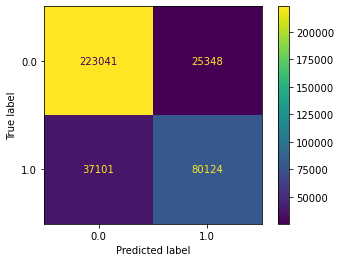

In [18]:
plot_confusion_matrix(clf_xgb, X_test, y_test, values_format='d')

In [19]:
params = {
    'max_depth': [3,4,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
    'scale_pos_weight': [1, 3, 5]
}

kfold = KFold(n_splits=2)

best_xgb = GridSearchCV(
    clf_xgb, param_grid=params, cv=3, verbose=0, n_jobs=-1)



In [ ]:
scores = cross_val_score(best_xgb, X_train, y_train, scoring='r2', cv=kfold) 
scores